### Data Generation & Loading

In [76]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Display options and warnings
import pandas as pd
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [78]:
import sys
sys.path.append('../lib')  # Import the lib directory to access the functions

import data_generation as dg  # Importing the functions

# Load the movie dataset
df_movies = pd.read_csv('../data/imdb_clean.csv')  # Ensure the CSV file is available
df_movies.index.name = 'movie_id'

# Create a DataFrame of users with usernames and passwords
num_users = 1000
df_users = dg.generate_users(num_users)

# Define available emotions
emotions = ['Happy', 'Down', 'Excited', 'Relaxed', 'Scared', 'Inspired', 'Sweet']

# Classify users into active and less active
active_users, less_active_users = dg.classify_users(df_users)

# Generate interactions
df_interactions = dg.generate_interactions(50000, df_movies, df_users, active_users, less_active_users, emotions)

# Generate favorites (30% of the viewed movies)
df_favorites = dg.generate_favorites(df_interactions)

# Generate ratings (50% of the favorite movies)
df_ratings = dg.generate_ratings(df_favorites, df_interactions)

# Save the generated data in CSV files
df_users.to_csv('../data/users.csv', index=False)
df_interactions.to_csv('../data/interactions.csv', index=False)
df_favorites.to_csv('../data/favorites.csv', index=False)
df_ratings.to_csv('../data/ratings.csv', index=False)

# MySQL connection
conn, cursor = dg.connect_to_mysql()

# Insert the generated data into MySQL
dg.insert_users(df_users, conn, cursor)
dg.insert_interactions(df_interactions, conn, cursor)
dg.insert_favorites(df_favorites, conn, cursor)
dg.insert_ratings(df_ratings, conn, cursor)

# Close the MySQL connection
conn.close()

### Exploratory Analysis

In [79]:
# Import necessary libraries
import pandas as pd
import sys
import matplotlib.pyplot as plt

# Add the lib directory to the system path to import functions
sys.path.append('../lib')

# Import the functions from data_analysis.py
import data_analysis as eda

# Load the CSVs into DataFrames
df_interactions = pd.read_csv('../data/interactions.csv')
df_favorites = pd.read_csv('../data/favorites.csv')
df_ratings = pd.read_csv('../data/ratings.csv')
df_users = pd.read_csv('../data/users.csv')

# Load the movie dataset to merge with the interaction data (if needed)
df_movies = pd.read_csv('../data/imdb_clean.csv')

# Load the list of active and less active users (assuming you have a function that returns them)
active_users = df_users.sample(frac=0.2)['user_id'].tolist()
less_active_users = df_users[~df_users['user_id'].isin(active_users)]['user_id'].tolist()

Interaction type distribution:
 interaction_type
shown    41363
view      8241
Name: count, dtype: int64


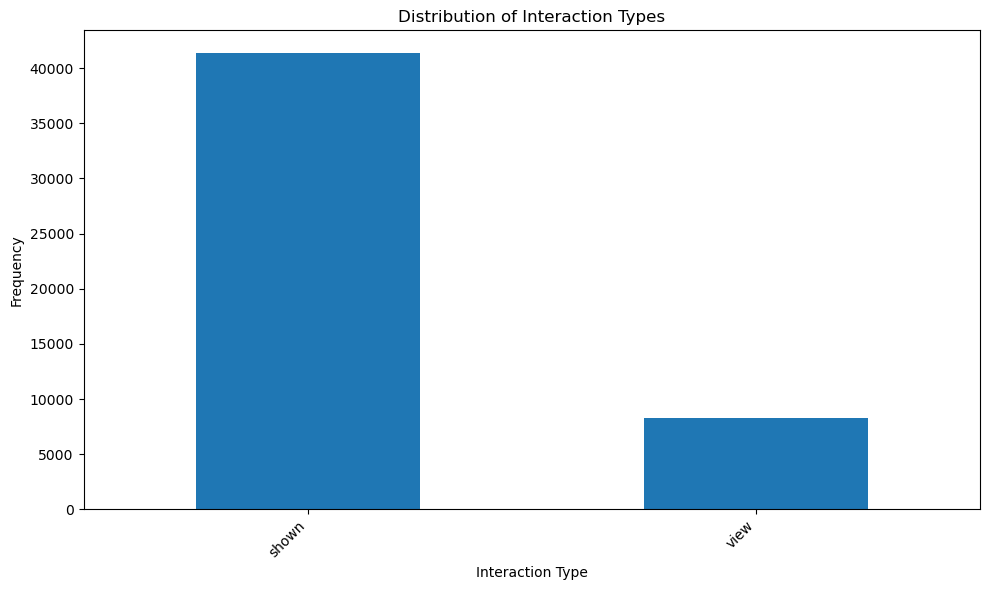

In [80]:
# Interaction type distribution
eda.interaction_type_distribution(df_interactions)

Emotion distribution in interactions:
 emotion
Happy       11592
Excited      9382
Relaxed      7717
Sweet        6945
Inspired     5287
Down         4749
Scared       3932
Name: count, dtype: int64


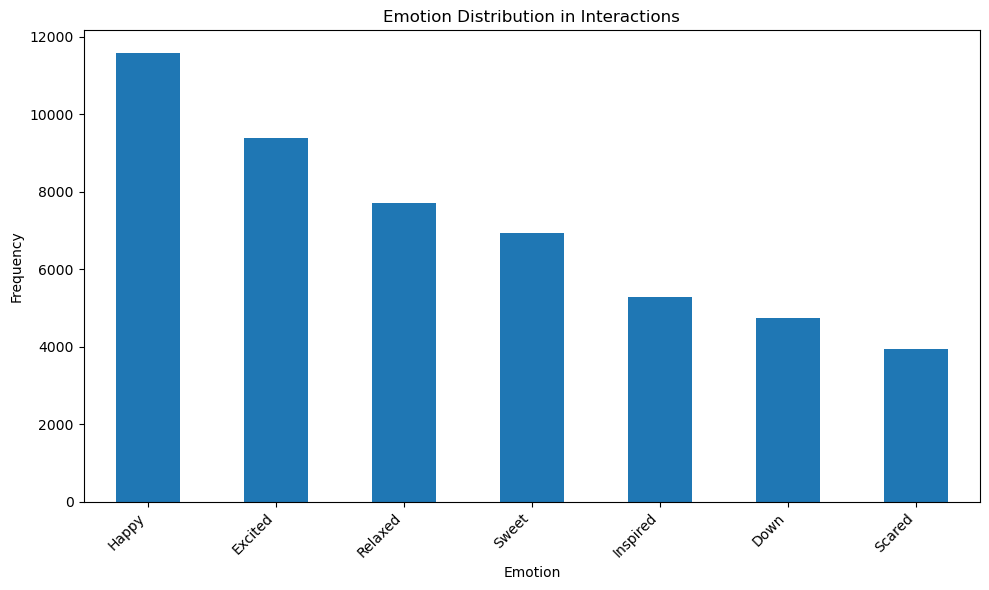

In [81]:
# Emotion distribution in interactions
eda.emotion_distribution_in_interactions(df_interactions)

Number of interactions per month:
 date
2023-10    1233
2023-11    4098
2023-12    4193
2024-01    4210
2024-02    3827
2024-03    4152
2024-04    4031
2024-05    4171
2024-06    4162
2024-07    4304
2024-08    4153
2024-09    4061
2024-10    3009
Freq: M, dtype: int64


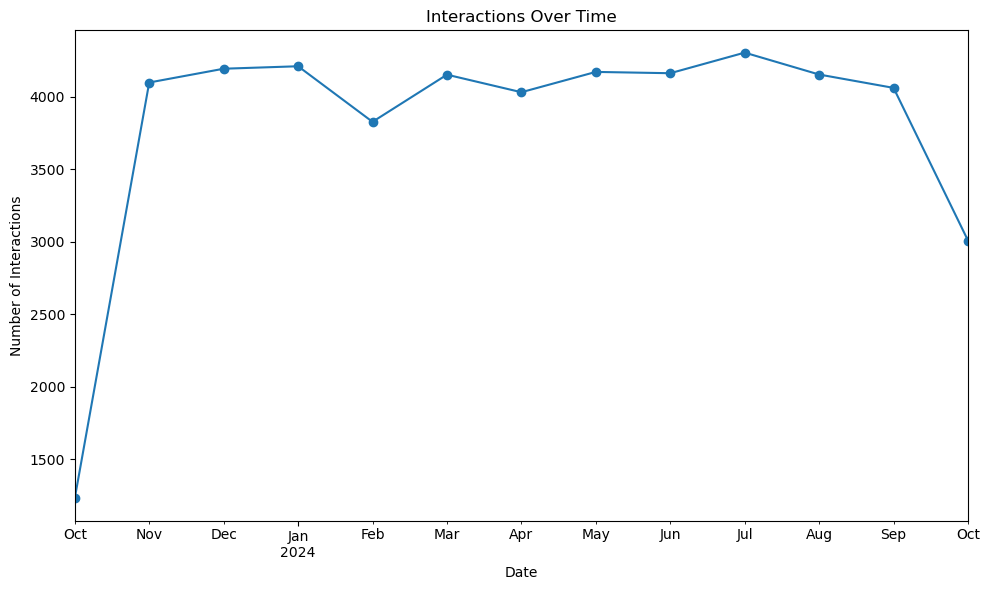

In [82]:
# Interactions over time
eda.interaction_over_time(df_interactions)

Favorites per user (Top 10):
 user_id
458    18
266    16
523    16
9      16
590    15
454    15
277    15
138    14
392    14
840    14
Name: count, dtype: int64


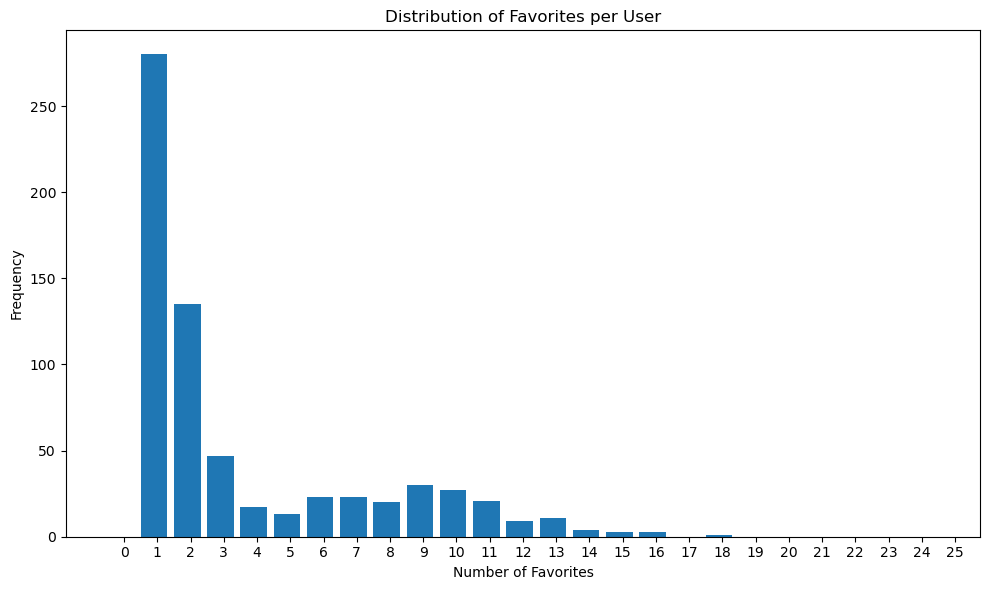

In [83]:
# Favorites per user
eda.favorites_per_user(df_favorites)

Emotion distribution in favorite movies:
 emotion
Happy       4229
Excited     2911
Relaxed     2904
Sweet       2301
Inspired    2235
Down        1440
Scared      1143
Name: count, dtype: int64


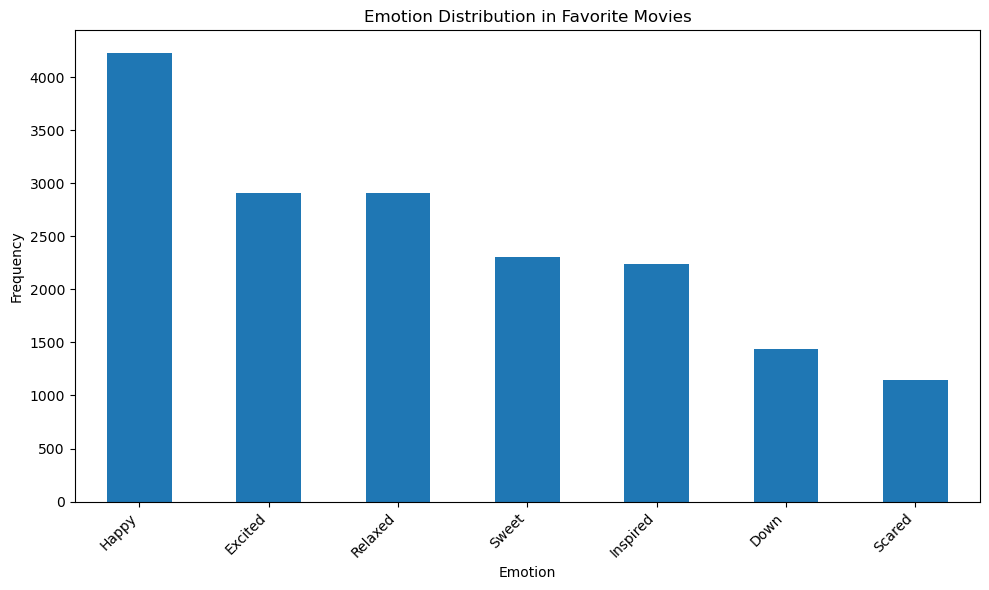

In [84]:
# Favorite emotion distribution
eda.favorite_emotion_distribution(df_favorites, df_interactions)

Rating distribution:
 rating
10    312
9     245
8     181
7     146
6     102
5      70
4      60
3      49
2      39
1      32
Name: count, dtype: int64


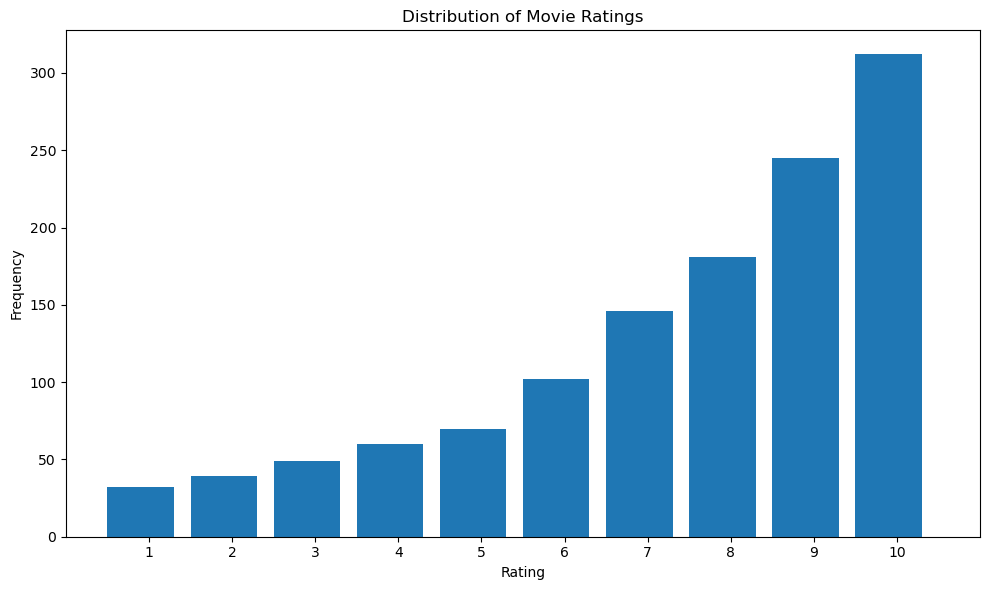

In [85]:
# Rating distribution
eda.rating_distribution(df_ratings)

Rating statistics by emotion:
            count      mean       std  min  25%  50%   75%   max
emotion                                                        
Down       706.0  7.358357  2.469771  1.0  6.0  8.0   9.0  10.0
Excited   1477.0  7.547732  2.374475  1.0  6.0  8.0   9.0  10.0
Happy     2116.0  7.648866  2.486094  1.0  6.0  9.0  10.0  10.0
Inspired  1177.0  7.197111  2.447800  1.0  6.0  8.0   9.0  10.0
Relaxed   1460.0  7.517808  2.420857  1.0  6.0  8.0  10.0  10.0
Scared     538.0  7.407063  2.481910  1.0  6.0  8.0   9.0  10.0
Sweet     1155.0  7.412121  2.468490  1.0  6.0  8.0   9.0  10.0


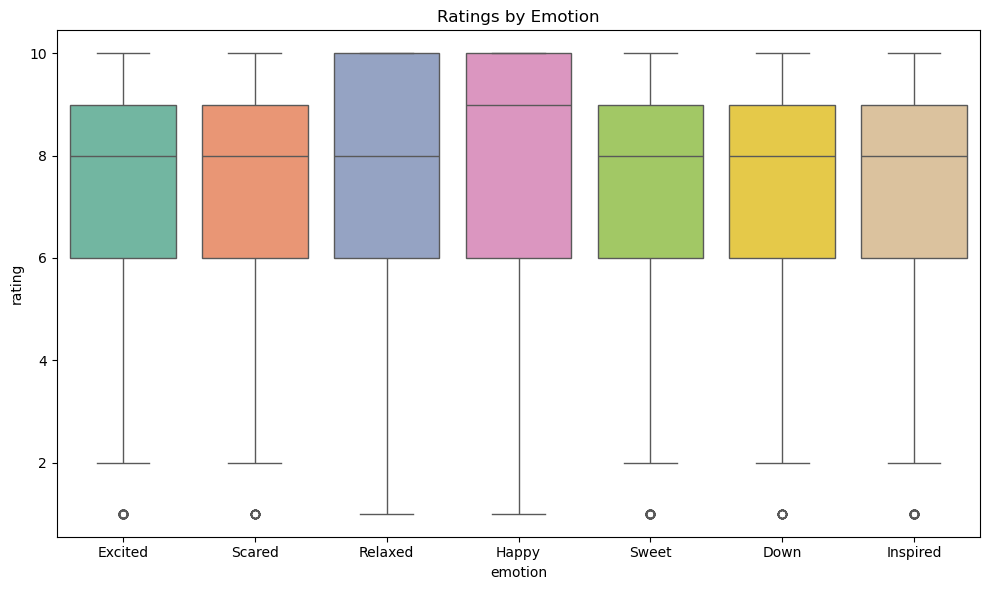

In [86]:
# Ratings by emotion
eda.ratings_by_emotion(df_ratings, df_interactions)

Active Users - Interaction Stats:
count    200.000000
mean      51.195000
std       63.569429
min        9.000000
25%       16.000000
50%       20.000000
75%       25.250000
max      194.000000
Name: count, dtype: float64

Less Active Users - Interaction Stats:
count    800.00000
mean      49.20625
std       61.81853
min        8.00000
25%       16.00000
50%       20.00000
75%       26.00000
max      213.00000
Name: count, dtype: float64


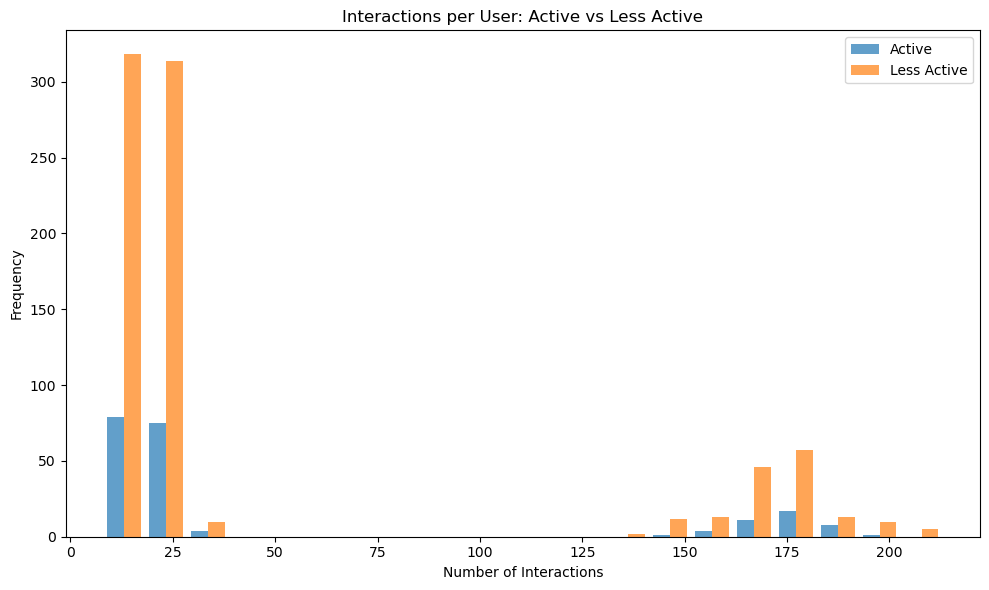

In [87]:
# Interactions per user type (active vs less active)
eda.interactions_per_user(df_interactions, active_users, less_active_users)

Total 'view' interactions: 8241
Views marked as favorites: 2472
Proportion of views that became favorites: 30.00%


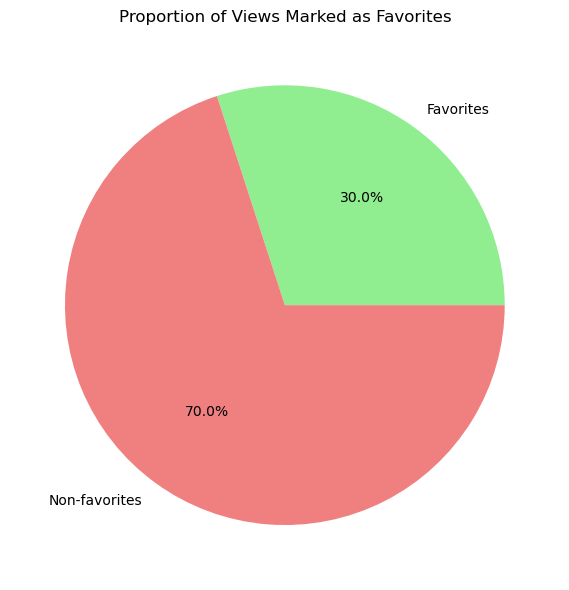

In [88]:
favorite_proportion = eda.analyze_favorites_from_views(df_interactions, df_favorites)

Rating Statistics by Emotion:
            count      mean       std  min  25%  50%   75%   max
emotion                                                        
Down       706.0  7.358357  2.469771  1.0  6.0  8.0   9.0  10.0
Excited   1477.0  7.547732  2.374475  1.0  6.0  8.0   9.0  10.0
Happy     2116.0  7.648866  2.486094  1.0  6.0  9.0  10.0  10.0
Inspired  1177.0  7.197111  2.447800  1.0  6.0  8.0   9.0  10.0
Relaxed   1460.0  7.517808  2.420857  1.0  6.0  8.0  10.0  10.0
Scared     538.0  7.407063  2.481910  1.0  6.0  8.0   9.0  10.0
Sweet     1155.0  7.412121  2.468490  1.0  6.0  8.0   9.0  10.0


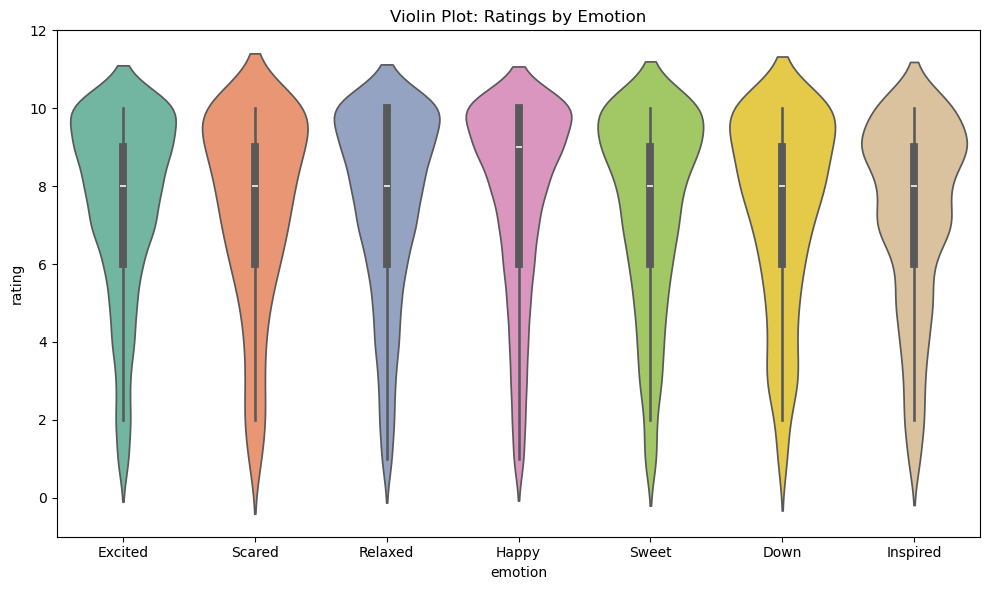

In [89]:
eda.violin_ratings_by_emotion(df_ratings, df_interactions)

Top 10 Most Recommended Movies (shown):
   movie_id  count                              title
0      1093     17                    Pan's Labyrinth
1      8121     16                  The Kid Detective
2      3145     16                     Mister Roberts
3       435     15                      The Big Short
4      5036     15        Girls Just Want to Have Fun
5      6840     15  Lagaan: Once Upon a Time in India
6      6960     15                     The First Time
7      7334     15                  Tôkyô goddofâzâzu
8      7667     15                           Drumline
9      1491     15                  Deepwater Horizon


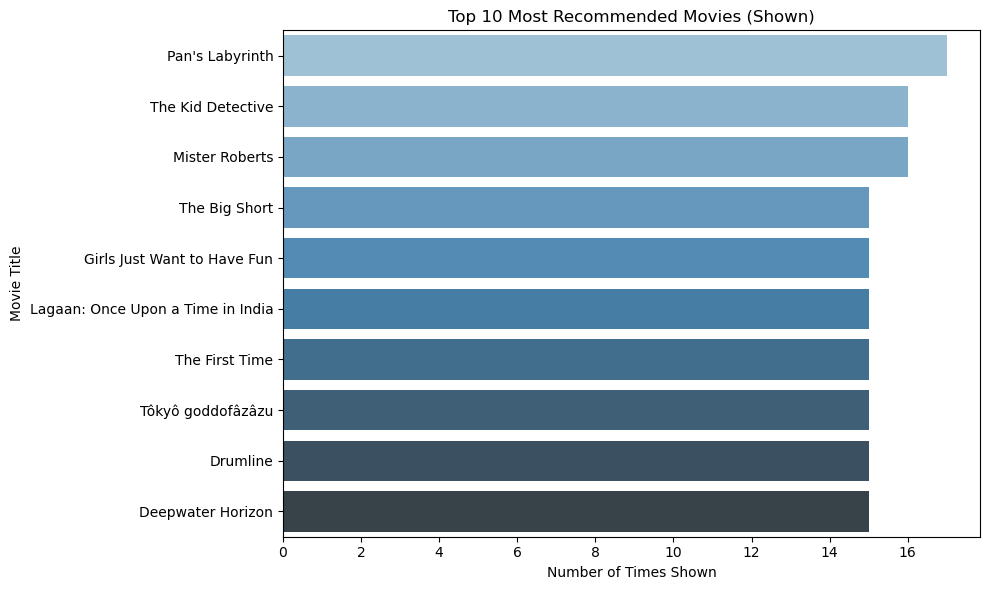

In [107]:
# Call the function to analyze the most recommended movies
eda.most_recommended_movies(df_interactions, df_movies)

Top 10 Favorite Directors (by number of interactions):
director
Steven Spielberg     181
Clint Eastwood       173
Martin Scorsese      156
Ridley Scott         155
Ron Howard           147
Steven Soderbergh    146
Woody Allen          141
Robert Zemeckis      110
Richard Linklater    108
Oliver Stone         102
Name: count, dtype: int64

Interactions per Year:
year
1929     275
1933     265
1934     297
1945     297
1954     249
1955     224
1961     221
1964     228
1965     542
1966     234
1968     261
1969     269
1971     266
1972     224
1973     264
1976     227
1977     233
1979     241
1981     459
1983     240
1985     730
1986     293
1988     207
1989     726
1990     290
1991     223
1992     447
1993     469
1994     506
1995    1210
1996    1059
1997     966
1998     499
1999    1040
2000     286
2001     712
2002    1521
2003     565
2004     782
2005    1021
2006    1509
2007    1285
2008     742
2009     819
2010     456
2011     776
2012    1351
2013     964
2014   

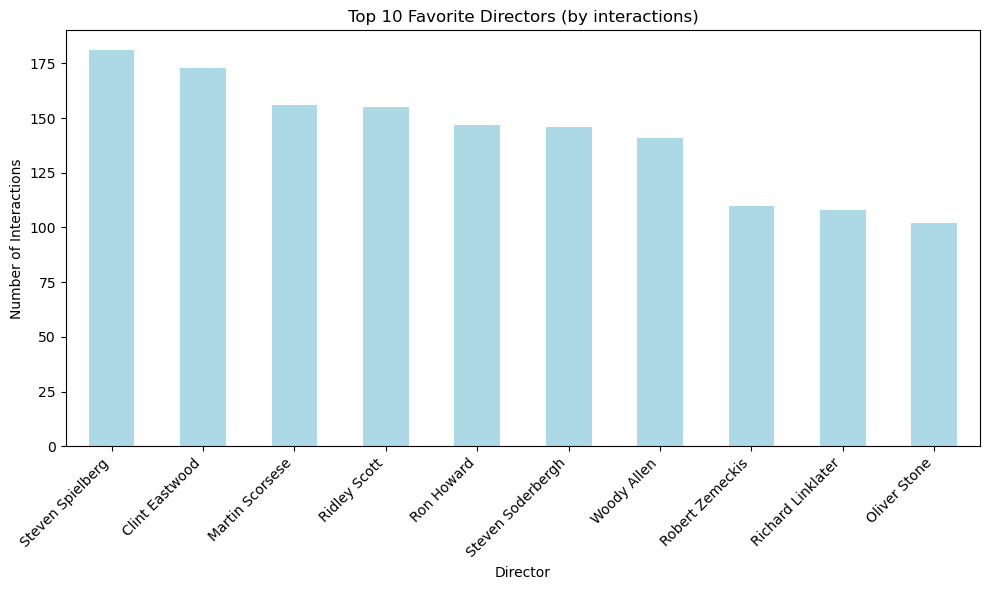

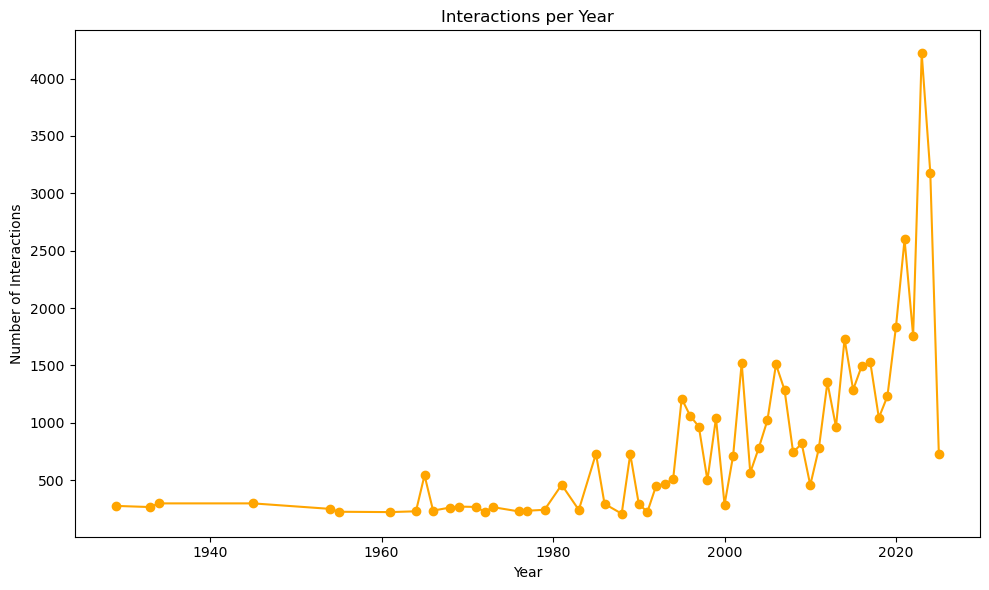

In [108]:
# Call the function to analyze favorite directors and interactions per year
eda.analyze_directors_years(df_interactions, df_movies)